In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [3]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [4]:
labels_pd.rename(columns={"index": "Unnamed: 0"}, inplace=True)

merged_df = pd.merge(counts_pd, labels_pd, on="Unnamed: 0")

X = merged_df.drop(columns=["Unnamed: 0", "bulk_labels"]).to_numpy()
y = merged_df["bulk_labels"].to_numpy()

In [5]:
le = LabelEncoder()
y_full = le.fit_transform(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_full, test_size=0.2, stratify=y_full, random_state=42)

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [154]:
len(X_test)/(len(x))

0.2

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(in_features=kwargs["input_shape"], out_features=128),
                                     nn.ReLU(),
                                     nn.Linear(in_features=128, out_features=64),
                                     nn.ReLU(),
                                     nn.Linear(in_features=64, out_features=kwargs["latent_space"]))
        
        self.decoder = nn.Sequential(nn.Linear(in_features=kwargs["latent_space"], out_features=64),
                                    nn.ReLU(),
                                    nn.Linear(in_features=64, out_features=128),
                                    nn.ReLU(),
                                    nn.Linear(in_features=128, out_features=kwargs["input_shape"]))
        
    def forward(self, features, return_encoding=False):
        encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        if return_encoding:
            return decoded, encoded
        return decoded

In [19]:
class TestClass():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def test(self, hyper):
        result_to_plot = {"batch":[], "lr":[], "latent":[], "epochs":[], "test_loss":[]}
        criterion = nn.MSELoss()
        best_loss = 100000
        best_parameters = None
        for batch in hyper["batch"]:
            train_loader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
            test_loader = DataLoader(dataset_test, batch_size=batch, shuffle=True)
            for lr in hyper["lr"]:
                for ls in hyper["latent_space"]:
                    model = Autoencoder(input_shape=765, latent_space=ls)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    for epoch in hyper["epochs"]:
                        for ep in range(epoch):
                            loss = 0
                            for batch_features, _ in train_loader:
                                batch_features = batch_features.view(-1, 765).to(self.device)
                                optimizer.zero_grad()

                                outputs, encoded = model(batch_features, return_encoding = True)
                                train_loss = criterion(outputs, batch_features)
                                train_loss.backward()
                                optimizer.step()
                                loss+=train_loss.item()
                            loss = loss/len(train_loader)
                            

                        model.eval()
                        total_test_loss = 0
                        with torch.no_grad():
                            for batch_features, _ in test_loader:
                                batch_features = batch_features.view(-1, 765).to(self.device)
                                output, _ = model(batch_features, return_encoding=True)
                                test_loss = criterion(output, batch_features)
                                total_test_loss += test_loss.item()
                            total_test_loss = total_test_loss/len(test_loader)
                            if total_test_loss < best_loss:
                                print("Best changed!")
                                best_loss = total_test_loss
                                best_parameters = {"ls":ls, "epoch":epoch, "batch":batch, "lr":lr}

                        print(f"Latent Dimension: {ls}, Epoch: {epoch}, Batch: {batch}, Lr: {lr}, Test Loss: {total_test_loss}")
                        result_to_plot["latent"].append(ls)
                        result_to_plot["batch"].append(batch)
                        result_to_plot["epochs"].append(epoch)
                        result_to_plot["lr"].append(lr)
                        result_to_plot["test_loss"].append(total_test_loss)
                        
        return result_to_plot, best_parameters

In [158]:
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)

dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataset_test = TensorDataset(X_tensor_test, y_tensor_test)

In [159]:
epochs = [30, 64, 128]
lrs = [1e-4, 1e-3, 0.01]
latent_dims = [24, 32, 45]
batches = [32, 64, 128]

hyperparameters = {"lr":lrs,
                  "epochs": epochs,
                  "latent_space": latent_dims,
                  "batch": batches}

In [160]:
tc = TestClass()
result_to_plot, best_parameters = tc.test(hyperparameters)

Best changed!
Latent Dimension: 24, Epoch: 30, Batch: 32, Lr: 0.0001, Test Loss: 0.9174736976623535
Best changed!
Latent Dimension: 24, Epoch: 64, Batch: 32, Lr: 0.0001, Test Loss: 0.8608407378196716
Best changed!
Latent Dimension: 24, Epoch: 128, Batch: 32, Lr: 0.0001, Test Loss: 0.8587885618209838
Latent Dimension: 32, Epoch: 30, Batch: 32, Lr: 0.0001, Test Loss: 0.899780011177063
Latent Dimension: 32, Epoch: 64, Batch: 32, Lr: 0.0001, Test Loss: 0.869443953037262
Best changed!
Latent Dimension: 32, Epoch: 128, Batch: 32, Lr: 0.0001, Test Loss: 0.8561741828918457
Latent Dimension: 45, Epoch: 30, Batch: 32, Lr: 0.0001, Test Loss: 0.904803204536438
Best changed!
Latent Dimension: 45, Epoch: 64, Batch: 32, Lr: 0.0001, Test Loss: 0.848943555355072
Latent Dimension: 45, Epoch: 128, Batch: 32, Lr: 0.0001, Test Loss: 0.8629293322563172
Latent Dimension: 24, Epoch: 30, Batch: 32, Lr: 0.001, Test Loss: 0.8940020799636841
Latent Dimension: 24, Epoch: 64, Batch: 32, Lr: 0.001, Test Loss: 0.9014

In [7]:
if not os.path.exists("test_training_result.csv"):
    df = pd.DataFrame(result_to_plot)
    df.to_csv("test_training_result.csv")
else:
    df = pd.read_csv("test_training_result.csv")

In [8]:
df

,Unnamed: 0,batch,lr,latent,epochs,test_loss
0,0,32,0.0001,24,30,0.917474
1,1,32,0.0001,24,64,0.860841
2,2,32,0.0001,24,128,0.858789
3,3,32,0.0001,32,30,0.899780
4,4,32,0.0001,32,64,0.869444
...,...,...,...,...,...,...
76,76,128,0.0100,32,64,0.845894
77,77,128,0.0100,32,128,0.931385
78,78,128,0.0100,45,30,0.901556
79,79,128,0.0100,45,64,0.888280


In [9]:
def get_comparison(df, parameter):
    df_new = df.groupby([parameter]).agg({"test_loss":"min"})
    df_new.reset_index(inplace=True, drop=False)
    return df_new

In [10]:
def plot_comparison(df):
    figs, axes = plt.subplots(2, 2, gridspec_kw={"width_ratios":[2, 2]})
    cols = [["batch", "lr"], ["latent", "epochs"]]
    for i in range(len(cols)):
        for j in range(len(cols[i])):
            current_name = cols[i][j]
            df_new = get_comparison(df, current_name)
            axes[i, j].plot(df_new[current_name], df_new["test_loss"], color="red")
            axes[i, j].set_title(f"test loss vs. {current_name}")
    
    plt.tight_layout()
    plt.show()

In [11]:
def get_best_params(df):
    best_params = None
    best_score = 1000000
    for i in range(len(df)):
        current_row = df.iloc[i, ]
        if current_row["test_loss"] < best_score:
            best_score = current_row["test_loss"] 
            best_params = current_row
    return best_params

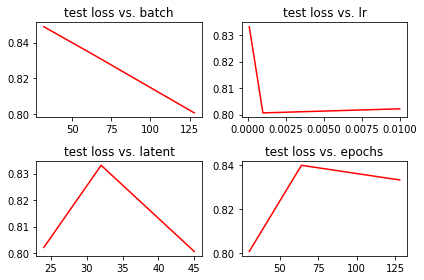

In [12]:
plot_comparison(df)

In [13]:
best_params = get_best_params(df)

In [40]:
best_params["latent"] = 32

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [41]:
best_params

Unnamed: 0     69.000000
batch         128.000000
lr              0.001000
latent         32.000000
epochs         30.000000
test_loss       0.800667
Name: 69, dtype: float64

In [15]:
def train(train_loader, best_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    criterion = nn.MSELoss()
    model = Autoencoder(input_shape=765, latent_space=int(best_params["latent"]))
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])

    for epoch in range(int(best_params["epochs"])):
        loss = 0
        for batch_feature, _ in train_loader:
            optimizer.zero_grad()
            batch_feature = batch_feature.view(-1, 765).to(device)
            outputs, encoding = model(batch_feature, return_encoding=True)
            current_loss = criterion(outputs, batch_feature)
            current_loss.backward()
            optimizer.step()
            loss+= current_loss.item()
        
        train_loss = loss/len(train_loader)
        print(f"Epoch: {epoch}, Train Loss: {train_loss}")
    
    return model

In [42]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_full, dtype=torch.long)

train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=int(best_params["batch"]), shuffle=True)

In [43]:
my_model = train(train_loader, best_params)

Epoch: 0, Train Loss: 1.0030523538589478
Epoch: 1, Train Loss: 1.006985604763031
Epoch: 2, Train Loss: 0.9915679395198822
Epoch: 3, Train Loss: 0.9702242712179819
Epoch: 4, Train Loss: 0.9388639628887177
Epoch: 5, Train Loss: 0.91338383158048
Epoch: 6, Train Loss: 0.8996198574701945
Epoch: 7, Train Loss: 0.8747459550698599
Epoch: 8, Train Loss: 0.8699805935223898
Epoch: 9, Train Loss: 0.8515815039475759
Epoch: 10, Train Loss: 0.8415098985036215
Epoch: 11, Train Loss: 0.8389656841754913
Epoch: 12, Train Loss: 0.8374711573123932
Epoch: 13, Train Loss: 0.8250384827454885
Epoch: 14, Train Loss: 0.8253150780995687
Epoch: 15, Train Loss: 0.8221808671951294
Epoch: 16, Train Loss: 0.8238848646481832
Epoch: 17, Train Loss: 0.8171854615211487
Epoch: 18, Train Loss: 0.8195050160090128
Epoch: 19, Train Loss: 0.80665123462677
Epoch: 20, Train Loss: 0.8080899814764658
Epoch: 21, Train Loss: 0.808726449807485
Epoch: 22, Train Loss: 0.8031844596068064
Epoch: 23, Train Loss: 0.7974993586540222
Epoch: 2

In [44]:
def get_latent_representation(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_encodings = []
    labels = []
    
    with torch.no_grad():
        for batch_feature, label in data_loader:
            batch_feature = batch_feature.view(-1, 765).to(device)
            outputs, encoding = model(batch_feature, return_encoding=True)
            all_encodings.append(encoding.cpu())
            labels.append(label)
    return torch.cat(all_encodings, dim=0), torch.cat(labels, dim=0)

In [45]:
X_tensor_full = torch.tensor(X, dtype=torch.float32)
y_tensor_full = torch.tensor(y_full, dtype=torch.long)
full_loader = DataLoader(TensorDataset(X_tensor_full, y_tensor_full), batch_size=int(best_params["batch"]), shuffle=False)
latent_representation, labels = get_latent_representation(full_loader, my_model)

In [46]:
len(latent_representation), len(X)

(700, 700)

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [48]:
def plot_2D(x, title, code, coloring):
    a1, a2 = [], []
    _ = [(a1.append(i[0]), a2.append(i[1])) for i in x]
    plt.scatter(a1, a2, c=coloring, alpha=0.4)
    plt.title(title.upper())
    if code == 1:
        plt.xlabel("tsne dimension 1")
        plt.ylabel("tsne dimension 2")
    else:
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")

In [49]:
tsne = TSNE()
tsne_without_latent = tsne.fit_transform(X)

In [50]:
pca = PCA(n_components=2)
pca_without_latent = pca.fit_transform(X)

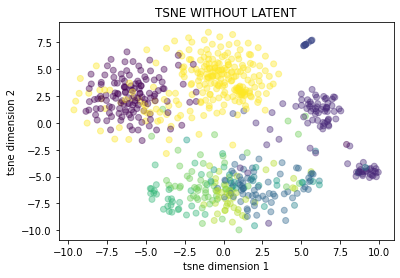

In [51]:
plot_2D(tsne_without_latent, "TSNE without latent", 1, coloring=y_full)

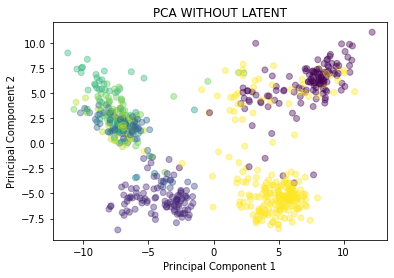

In [52]:
plot_2D(pca_without_latent, "PCA without latent",2, coloring=y_full)

Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

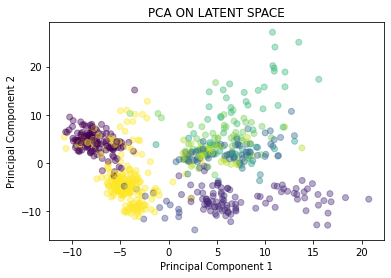

In [54]:
pca_latent = pca.fit_transform(latent_representation)
plot_2D(pca_latent, "PCA on latent space", 2, coloring=y_full)

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.